Importing Libraries

In [54]:
# Import Libraries
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_val_score
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
sns.set_theme()
%matplotlib inline

# Prevent warnings
import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

import keras
from scikeras.wrappers import KerasClassifier

In [55]:
# Dataset input
df = pd.read_csv("Indian Liver Patient Dataset (ILPD).csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 583 entries, 0 to 582
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Age        583 non-null    int64  
 1   Gender     583 non-null    object 
 2   TB         583 non-null    float64
 3   DB         583 non-null    float64
 4   Alkphos    583 non-null    int64  
 5   SGPT       583 non-null    int64  
 6   SGOT       583 non-null    int64  
 7   TP         583 non-null    float64
 8   ALB        583 non-null    float64
 9   A/G Ratio  579 non-null    float64
 10  Selector   583 non-null    int64  
dtypes: float64(5), int64(5), object(1)
memory usage: 50.2+ KB


In [56]:
print(df.describe())

              Age          TB          DB      Alkphos         SGPT  \
count  583.000000  583.000000  583.000000   583.000000   583.000000   
mean    44.746141    3.298799    1.486106   290.576329    80.713551   
std     16.189833    6.209522    2.808498   242.937989   182.620356   
min      4.000000    0.400000    0.100000    63.000000    10.000000   
25%     33.000000    0.800000    0.200000   175.500000    23.000000   
50%     45.000000    1.000000    0.300000   208.000000    35.000000   
75%     58.000000    2.600000    1.300000   298.000000    60.500000   
max     90.000000   75.000000   19.700000  2110.000000  2000.000000   

              SGOT          TP         ALB   A/G Ratio    Selector  
count   583.000000  583.000000  583.000000  579.000000  583.000000  
mean    109.910806    6.483190    3.141852    0.947064    1.286449  
std     288.918529    1.085451    0.795519    0.319592    0.452490  
min      10.000000    2.700000    0.900000    0.300000    1.000000  
25%      25.000

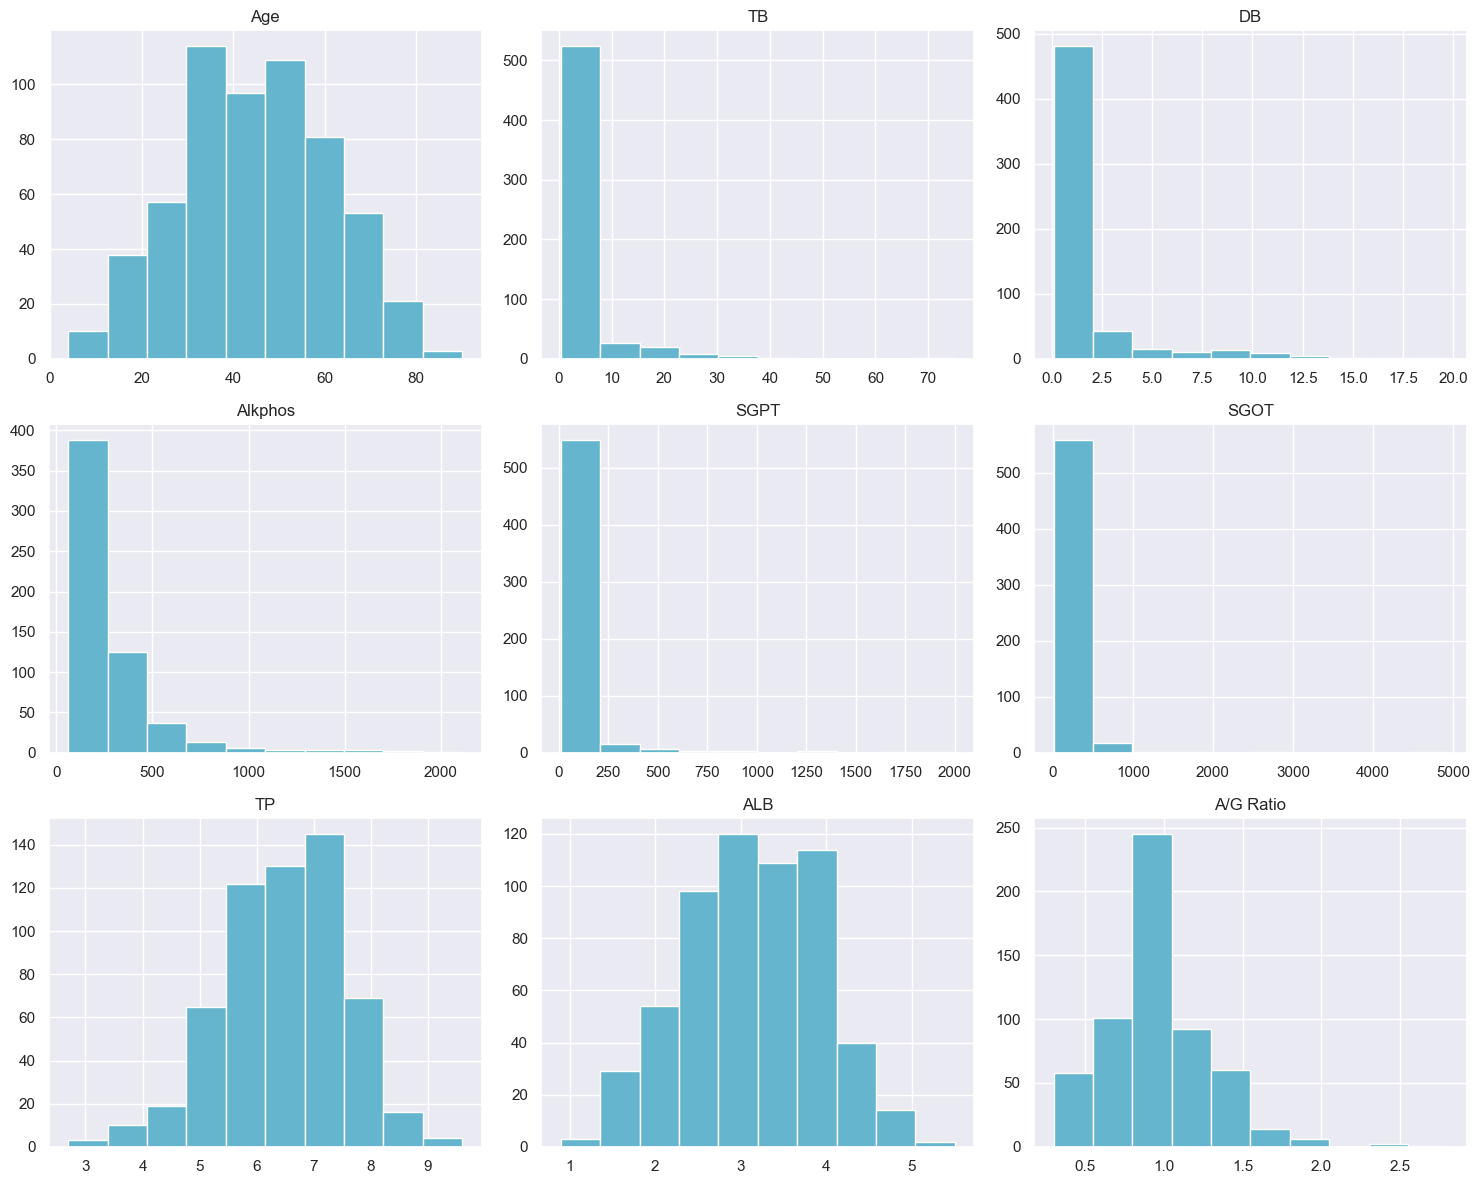

In [57]:
pltdf = df.copy(deep=True)
pltdf.drop(['Selector'], axis=1, inplace=True)
pltdf.hist(figsize=(15,12), color='c')
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.45, hspace=0.45)
plt.tight_layout()
plt.show()

# for column in df.drop(['Selector', 'Gender'], axis=1):
#     sns.histplot(x = df[column], palette="winter_r", kde=True)
#     plt.show()
    

In [58]:
# Identify Null values
df.isnull().sum()

Age          0
Gender       0
TB           0
DB           0
Alkphos      0
SGPT         0
SGOT         0
TP           0
ALB          0
A/G Ratio    4
Selector     0
dtype: int64

In [59]:
# Replace Null values with the mean of the column
AGRatio_mean = df['A/G Ratio'].mean(numeric_only=True)
df.fillna(AGRatio_mean, inplace=True)

# Encode Gender
df['Gender'] = df['Gender'].map({'Female': 0, 'Male': 1})

                Age    Gender        TB        DB   Alkphos      SGPT  \
Age        1.000000  0.056560  0.011763  0.007529  0.080425 -0.086883   
Gender     0.056560  1.000000  0.089291  0.100436 -0.027496  0.082332   
TB         0.011763  0.089291  1.000000  0.874618  0.206669  0.214065   
DB         0.007529  0.100436  0.874618  1.000000  0.234939  0.233894   
Alkphos    0.080425 -0.027496  0.206669  0.234939  1.000000  0.125680   
SGPT      -0.086883  0.082332  0.214065  0.233894  0.125680  1.000000   
SGOT      -0.019910  0.080336  0.237831  0.257544  0.167196  0.791966   
TP        -0.187461 -0.089121 -0.008099 -0.000139 -0.028514 -0.042518   
ALB       -0.265924 -0.093799 -0.222250 -0.228531 -0.165453 -0.029742   
A/G Ratio -0.216089 -0.003404 -0.206159 -0.200004 -0.233960 -0.002374   
Selector  -0.137351 -0.082416 -0.220208 -0.246046 -0.184866 -0.163416   

               SGOT        TP       ALB  A/G Ratio  Selector  
Age       -0.019910 -0.187461 -0.265924  -0.216089 -0.137351

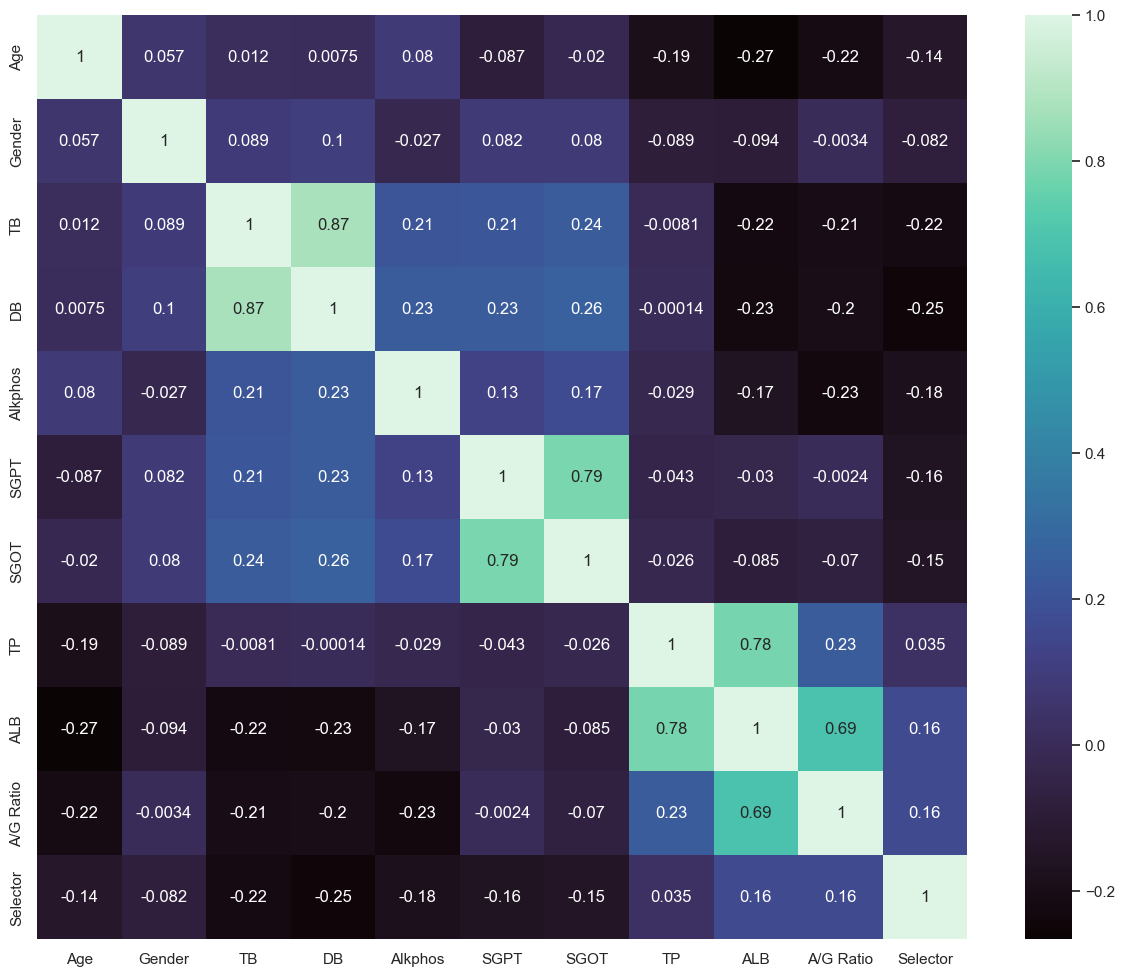

In [60]:
# Correlation of features
print(df.corr())

# Heatmap
plt.figure(figsize=(15,12))
sns.heatmap(df.corr(), annot=True, cmap='mako')
plt.show()

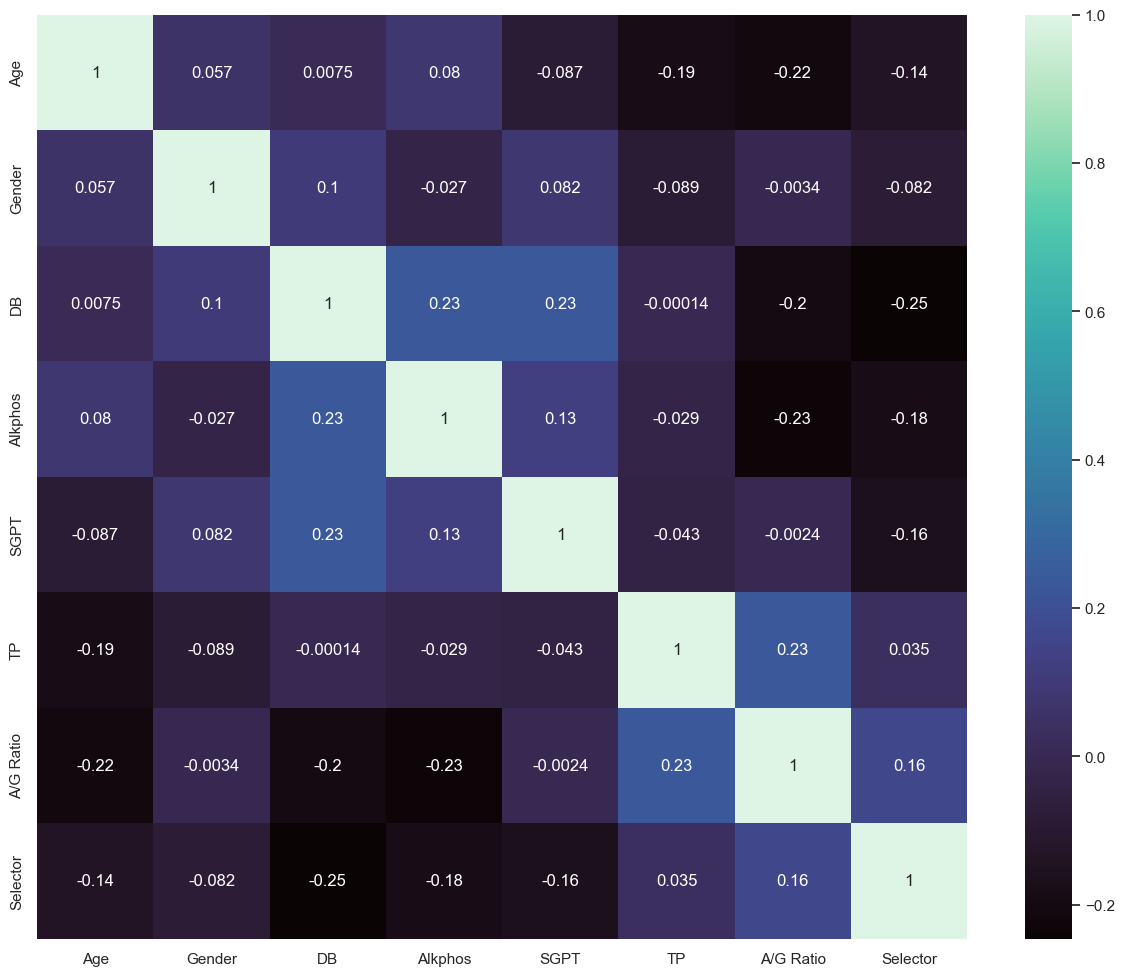

In [61]:
# Remove highly correlated features
df.drop(['TB','ALB','SGOT'], axis=1, inplace=True)

# Heatmap
plt.figure(figsize=(15,12))
sns.heatmap(df.corr(), annot=True, cmap='mako')
plt.show()

In [62]:
def Calc_IQR(column):
    """
    Calculates Interquartile Range for the removal of outliers

    Args:
        column (string): label of the current column of the DataFrame

    Returns:
        IQR (float): interquartile range
        upper (float): upper limit
        lower (float): lower limit
    """
    Q1 = np.percentile(df[column], 25, method='midpoint')
    Q3 = np.percentile(df[column], 75, method='midpoint')
    IQR = Q3 - Q1
    upper = Q3 + 1.5 * IQR
    lower = Q1 - 1.5 * IQR
    return IQR, upper, lower

def Remove_Outliers(column):
    """
    Detects and removes outliers using IQR

    Args:
        column (string): label of the current column of the DataFrame
    """
    IQR, upper, lower = Calc_IQR(column)
    upper_array = np.where(pltdf[column] >= upper)[0]
    lower_array = np.where(pltdf[column] <= lower)[0]
    outliers_column = np.concatenate((upper_array, lower_array))
    pltdf.drop(index=outliers_column, inplace=True)
    pltdf.reset_index(inplace=True, drop=True)

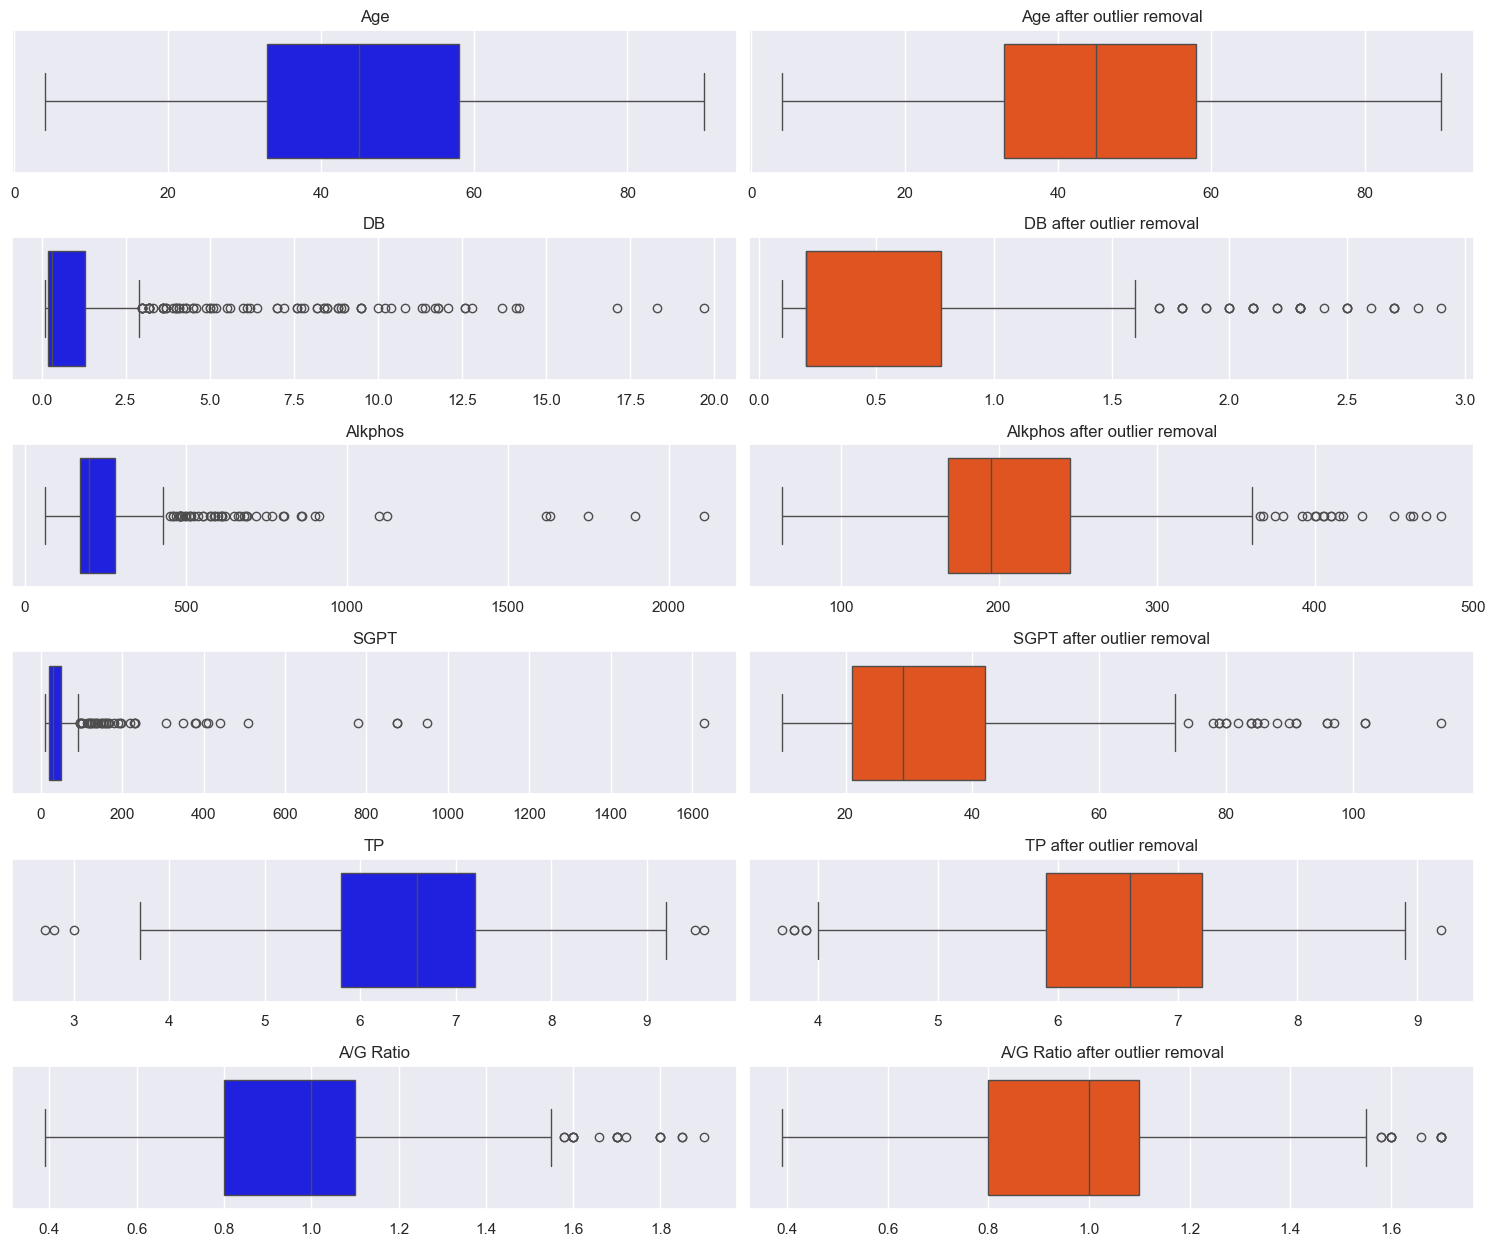

In [63]:
plt.figure(figsize=(15, 12.5))
pltdf = df.copy(deep=True)
for i, column in enumerate(pltdf.drop(['Selector','Gender'], axis=1)):
    plt.subplot(6,2,i*2+1)
    sns.boxplot(pltdf[column], color='blue', orient='h')
    plt.title(column)
    plt.xlabel('')

    Remove_Outliers(column)

    plt.subplot(6,2,i*2+2)
    sns.boxplot(pltdf[column], color='orangered', orient='h')
    plt.title(column + ' after outlier removal')
    plt.xlabel('')

plt.tight_layout(pad=0.7, w_pad=0.5, h_pad=1.0)

In [64]:
# Scaling data using StandardScaler()
from sklearn.preprocessing import StandardScaler, RobustScaler
scaler = RobustScaler()
df = scaler.fit_transform(df)

In [65]:
# Separate feature vectors(X) and labels(y)
y = np.transpose(df)[7]
X = np.delete(df, 7, 1)

# Split Dataset
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=42)

In [66]:
# Convert to numpy arrays
X_train = np.asarray(X_train).astype(np.float64)
y_train = np.asarray(y_train).astype(np.float64)
X_val = np.asarray(X_val).astype(np.float64)
y_val = np.asarray(y_val).astype(np.float64)

input_shape = [X.shape[1]]

In [67]:
# Encode Labels
from sklearn.preprocessing import LabelEncoder
lab = LabelEncoder()
y_traintransformed = lab.fit_transform(y_train)
y_valtransformed = lab.fit_transform(y_val)

In [68]:
# Apply SMOTE to balance the classes
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_traintransformed)

print("Training set class distribution after SMOTE:")
print(pd.Series(y_train_balanced).value_counts())

Training set class distribution after SMOTE:
0    307
1    307
Name: count, dtype: int64


In [69]:
def create_model():
    # Neural Network Configuration
    Neural_Network = keras.Sequential([keras.Input(shape=input_shape),
                                    keras.layers.Dense(units=4, activation='tanh'),
                                    keras.layers.Dense(units=4, activation='tanh'),
                                    keras.layers.Dense(units=1, activation='sigmoid')])
    optimizer = keras.optimizers.Adam(learning_rate=1e-3)
    Neural_Network.compile(optimizer=optimizer, loss='binary_crossentropy')
    Neural_Network.summary()
    return Neural_Network

In [70]:
# # Cross-validation
# estimator = KerasClassifier(model=create_model, epochs=100, batch_size=200, verbose=0)
# cross_val = cross_val_score(estimator, X_train, y_traintransformed, cv=10)
# print(cross_val.mean() ,cross_val.std())

In [71]:
# Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

rf_model = RandomForestClassifier(n_estimators=90, random_state=42)

rf_model.fit(X_train, y_traintransformed)
y_pred = rf_model.predict(X_val)
rf_train_accuracy = accuracy_score(y_traintransformed, rf_model.predict(X_train))
rf_val_accuracy = accuracy_score(y_valtransformed, y_pred)

print("Train Accuracy: ", rf_train_accuracy)
print("Validation Accuracy: ", rf_val_accuracy, "\n")

print(classification_report(y_valtransformed, y_pred))
print(confusion_matrix(y_valtransformed, y_pred))

Train Accuracy:  1.0
Validation Accuracy:  0.7671232876712328 

              precision    recall  f1-score   support

           0       0.82      0.88      0.85       109
           1       0.55      0.43      0.48        37

    accuracy                           0.77       146
   macro avg       0.69      0.66      0.67       146
weighted avg       0.75      0.77      0.76       146

[[96 13]
 [21 16]]


In [72]:
# Support Vector Machine
def compute_val_error(val, prediction):
    return 1 - np.mean(prediction == val)

SVC_model = SVC(kernel='rbf')
SVC_model.fit(X_train, y_traintransformed)
pred_val_y = SVC_model.predict(X_val)

val_error = compute_val_error(y_valtransformed, pred_val_y)
print("Validation Error:", val_error)

SVC_accuracy = 1 - val_error
print("Accuracy: ", SVC_accuracy)

Validation Error: 0.2534246575342466
Accuracy:  0.7465753424657534


In [73]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression()

lr_model.fit(X_train, y_traintransformed)
y_pred = lr_model.predict(X_val)
lr_train_accuracy = accuracy_score(y_traintransformed, lr_model.predict(X_train))
lr_val_accuracy = accuracy_score(y_valtransformed, y_pred)

print("Train accuracy: ", lr_train_accuracy)
print("Validation accuracy: ", lr_val_accuracy, "\n")

print(classification_report(y_valtransformed, y_pred))
print(confusion_matrix(y_valtransformed, y_pred))

Train accuracy:  0.7185354691075515
Validation accuracy:  0.6986301369863014 

              precision    recall  f1-score   support

           0       0.75      0.89      0.82       109
           1       0.29      0.14      0.19        37

    accuracy                           0.70       146
   macro avg       0.52      0.51      0.50       146
weighted avg       0.64      0.70      0.66       146

[[97 12]
 [32  5]]


In [74]:
# Decision Tree Classifier
from sklearn.tree import DecisionTreeClassifier

dtc_model = DecisionTreeClassifier()

dtc_model.fit(X_train, y_traintransformed)
y_pred = dtc_model.predict(X_val)
dtc_train_accuracy = accuracy_score(y_traintransformed, dtc_model.predict(X_train))
dtc_val_accuracy = accuracy_score(y_valtransformed, y_pred)

print("Train accuracy: ", dtc_train_accuracy)
print("Validation accuracy: ", dtc_val_accuracy, "\n")

print(classification_report(y_valtransformed, y_pred))
print(confusion_matrix(y_valtransformed, y_pred))

Train accuracy:  1.0
Validation accuracy:  0.7123287671232876 

              precision    recall  f1-score   support

           0       0.83      0.78      0.80       109
           1       0.44      0.51      0.47        37

    accuracy                           0.71       146
   macro avg       0.63      0.65      0.64       146
weighted avg       0.73      0.71      0.72       146

[[85 24]
 [18 19]]


In [75]:
# from sklearn.ensemble import GradientBoostingClassifier
# from sklearn.model_selection import GridSearchCV

# gbc = GradientBoostingClassifier()

# parameters = {
#     'loss': ['deviance', 'exponential'],
#     'learning_rate': [0.001, 0.1, 1, 10],
#     'n_estimators': [100, 150, 180, 200]
# }

# grid_search_gbc = GridSearchCV(gbc, parameters, cv = 20, n_jobs = -1, verbose = 1)
# grid_search_gbc.fit(X_train, y_traintransformed)
# grid_search_gbc.best_params_
# grid_search_gbc.best_score_
# gbc = GradientBoostingClassifier(learning_rate=0.001, loss='exponential',n_estimators=100)
# gbc.fit(X_train, y_traintransformed)
# print(accuracy_score(y_train, gbc.predict(X_train)))
# gbc_accuracy = accuracy_score(y_valtransformed, gbc.predict(X_val))
# print(gbc_accuracy)
# print(confusion_matrix(y_valtransformed, gbc.predict(X_val)))
# print(classification_report(y_valtransformed, gbc.predict(X_val)))

Gradient Boosting

In [76]:
# XGBoost:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(objective='binary:logistic', learning_rate = 0.001, max_depth = 100, n_estimators = 300)

xgb_model.fit(X_train, y_traintransformed)
y_pred = xgb_model.predict(X_val)
xgb_train_accuracy = accuracy_score(y_traintransformed, xgb_model.predict(X_train))
xgb_val_accuracy = accuracy_score(y_valtransformed, y_pred)

print("Train accuracy: ", xgb_train_accuracy)
print("Validation accuracy: ", xgb_val_accuracy, "\n")

print(classification_report(y_valtransformed, y_pred))
print(confusion_matrix(y_valtransformed, y_pred))

Train accuracy:  0.7025171624713958
Validation accuracy:  0.7465753424657534 

              precision    recall  f1-score   support

           0       0.75      1.00      0.85       109
           1       0.00      0.00      0.00        37

    accuracy                           0.75       146
   macro avg       0.37      0.50      0.43       146
weighted avg       0.56      0.75      0.64       146

[[109   0]
 [ 37   0]]


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

In [77]:
# LightGBM:
from lightgbm import LGBMClassifier

lgbm_model = LGBMClassifier(random_state=42)

lgbm_model.fit(X_train, y_traintransformed)
y_pred = lgbm_model.predict(X_val)
lgbm_train_accuracy = accuracy_score(y_traintransformed, lgbm_model.predict(X_train))
lgbm_val_accuracy = accuracy_score(y_valtransformed, y_pred)

print("Train accuracy: ", lgbm_train_accuracy)
print("Validation accuracy: ", lgbm_val_accuracy, "\n")

print(classification_report(y_valtransformed, y_pred))
print(confusion_matrix(y_valtransformed, y_pred))

[LightGBM] [Info] Number of positive: 130, number of negative: 307
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000868 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 348
[LightGBM] [Info] Number of data points in the train set: 437, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.297483 -> initscore=-0.859313
[LightGBM] [Info] Start training from score -0.859313
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


In [78]:
# Stacking Classifier
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

# Define individual learners
base_learners = [
    ('rf', rf_model),
    ('xgb', xgb_model),
    ('nn', KerasClassifier(model=create_model, epochs=100, batch_size=200))
]

stacking_clf = StackingClassifier(estimators=base_learners, final_estimator=LogisticRegression(class_weight='balanced'))

stacking_clf.fit(X_train, y_traintransformed)
y_pred = stacking_clf.predict(X_val)
stacking_clf_train_accuracy = accuracy_score(y_traintransformed, stacking_clf.predict(X_train))
stacking_clf_val_accuracy = accuracy_score(y_valtransformed, y_pred)

print("Train accuracy: ", stacking_clf_train_accuracy)
print("Validation accuracy: ", stacking_clf_val_accuracy, "\n")

print(classification_report(y_valtransformed, y_pred))
print(confusion_matrix(y_valtransformed, y_pred))

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_18 (Dense)                │ (None, 4)              │            32 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 4)              │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57 (228.00 B)

 Trainable params: 57 (228.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 0s/step - loss: 0.7764
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step - loss: 0.7718  
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step - loss: 0.7634  
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step - loss: 0.7546  
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step - loss: 0.7448  
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7383 
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7327 
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7267 
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step - loss: 0.7160  
Epoch 10/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step - loss: 0.7101  
Epoch 11/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7038 
Epoch 12/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step - loss: 0.7025  
Epoch 13/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step - loss: 0.6948  
Epoch 14/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.6891 
Epoch 15/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.6865 
Epoch 16/100
3/3 ━━━━

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_21 (Dense)                │ (None, 4)              │            32 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 4)              │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57 (228.00 B)

 Trainable params: 57 (228.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.6431
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6404  
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.6403
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.6367
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.6325
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.6297  
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.6329 
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6325  
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6274 
Epoch 10/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6264  
Epoch 11/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6225 
Epoch 12/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6199 
Epoch 13/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6179 
Epoch 14/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.6217
Epoch 15/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6219 
Epoch 16/100
2/2

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_24 (Dense)                │ (None, 4)              │            32 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 4)              │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57 (228.00 B)

 Trainable params: 57 (228.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.6873
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6859 
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6831 
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6833 
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6792 
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6787  
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6764 
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6750 
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6720 
Epoch 10/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6706 
Epoch 11/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6704 
Epoch 12/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6686 
Epoch 13/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6652 
Epoch 14/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6616 
Epoch 15/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6610 
Epoch 16/100
2/2 ━━

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_27 (Dense)                │ (None, 4)              │            32 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 4)              │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57 (228.00 B)

 Trainable params: 57 (228.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.7024
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7022 
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7010 
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.6983 
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6962  
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.6915
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6917 
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6890 
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6875 
Epoch 10/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6873 
Epoch 11/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6842 
Epoch 12/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6798 
Epoch 13/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6772 
Epoch 14/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6750 
Epoch 15/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6739  
Epoch 16/100
2/2 ━

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_30 (Dense)                │ (None, 4)              │            32 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 4)              │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57 (228.00 B)

 Trainable params: 57 (228.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.6992
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step - loss: 0.6915  
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step - loss: 0.6926  
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step - loss: 0.6926  
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step - loss: 0.6819  
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.6815
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step - loss: 0.6724  
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.6762
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step - loss: 0.6681  
Epoch 10/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.6690
Epoch 11/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.6656
Epoch 12/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.6595
Epoch 13/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step - loss: 0.6559  
Epoch 14/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step - loss: 0.6606  
Epoch 15/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step - loss: 0.6541  
Epoch 16/100
2/2 ━━

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_33 (Dense)                │ (None, 4)              │            32 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 4)              │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57 (228.00 B)

 Trainable params: 57 (228.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.7457
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7496 
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7383 
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7284 
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7317 
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7273 
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.7282
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7156 
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7083 
Epoch 10/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.7173
Epoch 11/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.7093
Epoch 12/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7049 
Epoch 13/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step - loss: 0.7037   
Epoch 14/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step - loss: 0.6955  
Epoch 15/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.6979
Epoch 16/100
2/2 ━

In [79]:
models = pd.DataFrame({
    'Model':['Random Forest Classifier', 'SVC', 'Logistic Regression', 'Decision Tree Classifier', 'XGBoost', 'LightGBM', 'Stacking Classifier'],
    'Train Accuracy':[round(rf_train_accuracy, 4)*100, round(SVC_accuracy, 4)*100, round(lr_train_accuracy, 4)*100, round(dtc_train_accuracy, 4)*100, round(xgb_train_accuracy, 4)*100, round(lgbm_train_accuracy, 4)*100, round(stacking_clf_train_accuracy, 4)*100],
    'Validation Accuracy':[round(rf_val_accuracy, 4)*100, round(SVC_accuracy, 4)*100, round(lr_val_accuracy, 4)*100, round(dtc_val_accuracy, 4)*100, round(xgb_val_accuracy, 4)*100, round(lgbm_val_accuracy, 4)*100, round(stacking_clf_val_accuracy, 4)*100]
})

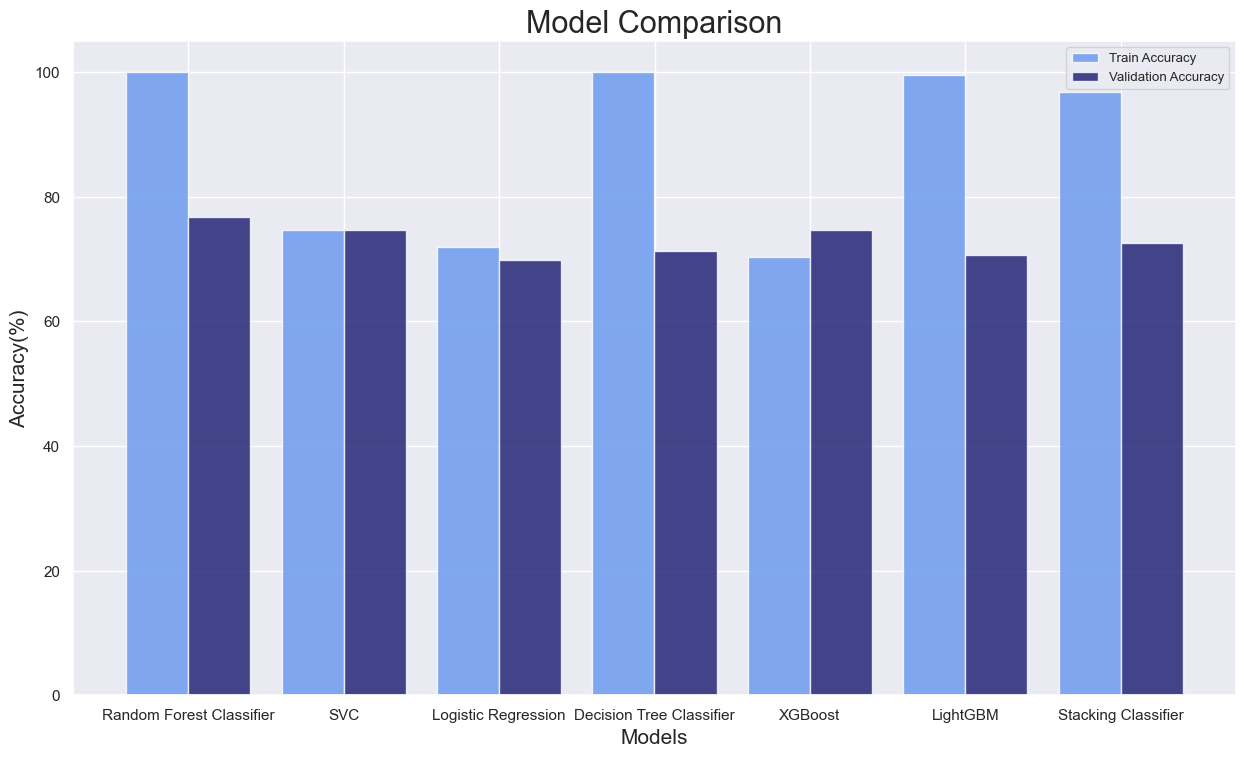

In [127]:
plt.figure(figsize=(15, 8.5))
index = np.arange(7)
barwidth = 0.4
plt.bar(index, models['Train Accuracy'], width=barwidth, color='cornflowerblue', alpha=0.8, label='Train Accuracy')
plt.bar(index+barwidth, models['Validation Accuracy'], width=barwidth, color='midnightblue', alpha=0.8, label='Validation Accuracy')

plt.title('Model Comparison', fontsize=22)
plt.xticks(index+barwidth/2, models['Model'])
plt.xlabel('Models', fontsize=15)
plt.ylabel('Accuracy(%)', fontsize=15)
plt.legend(loc='upper right', fontsize=9.5)

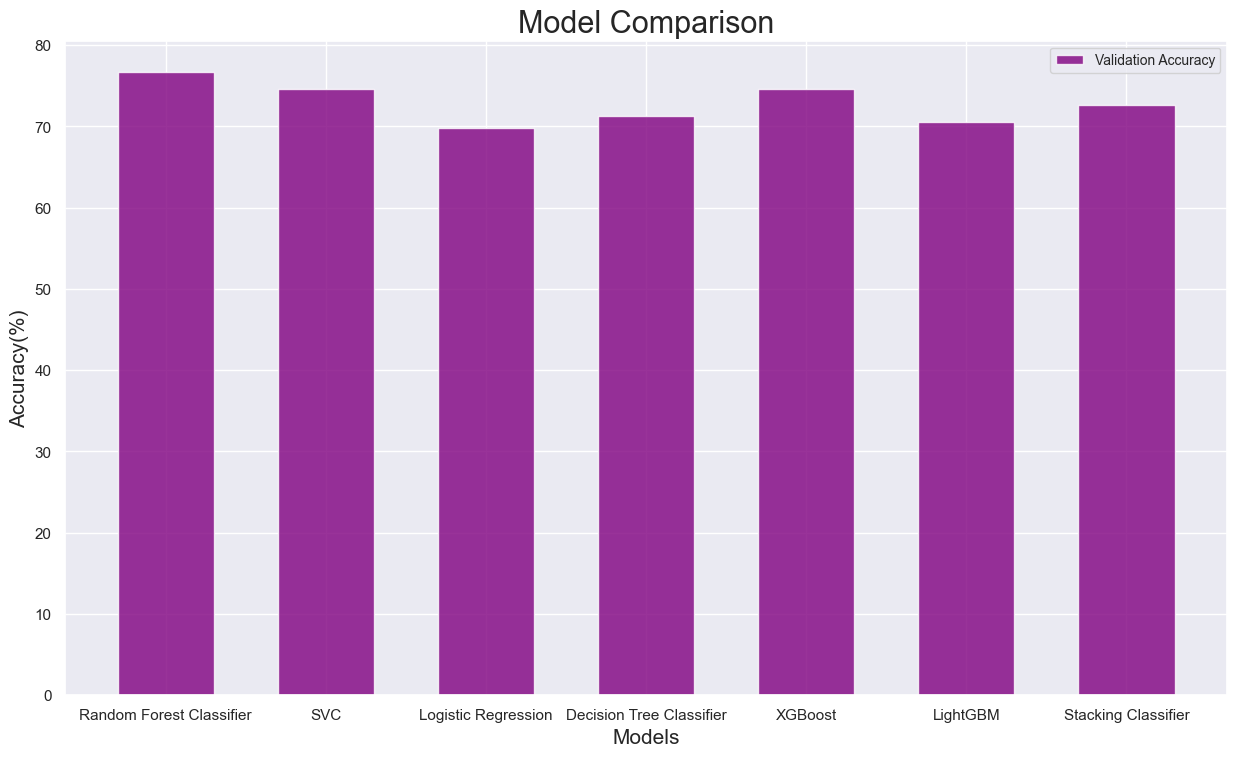

In [105]:
plt.figure(figsize=(15, 8.5))
index = np.arange(7)
plt.bar(models['Model'], models['Validation Accuracy'], width=0.6, color='purple', alpha=0.8, label='Validation Accuracy')

plt.title('Model Comparison', fontsize=22)
plt.xlabel('Models', fontsize=15)
plt.ylabel('Accuracy(%)', fontsize=15)
plt.legend(loc='upper right', fontsize=10)

In [81]:
# from sklearn import metrics
# plt.figure(figsize=(8,5))
# models = [
# {
#     'label': 'LR',
#     'model': lr_model,
# },
# {
#     'label': 'DT',
#     'model': dtc_model,
# },
# # {
# #     'label': 'SVM',
# #     'model': SVC_model,
# # },
# {
#     'label': 'LightGBM',
#     'model': lgbm_model,
# },
# {
#     'label': 'XGBoost',
#     'model': xgb_model,
# },
# {
#     'label': 'RF',
#     'model': rf_model,
# },
# {
#     'label': 'Stack clf',
#     'model': stacking_clf,
# }
# ]
# for m in models:
#     model = m['model'] 
#     model.fit(X_train, y_train) 
#     y_pred=model.predict(X_val) 
#     fpr1, tpr1, thresholds = metrics.roc_curve(y_valtransformed, model.predict_proba(X_val)[:,1])
#     auc = metrics.roc_auc_score(y_valtransformed,model.predict(X_val))
#     plt.plot(fpr1, tpr1, label='%s - ROC (area = %0.2f)' % (m['label'], auc))

# plt.plot([0, 1], [0, 1],'r--')
# plt.xlim([-0.01, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('1 - Specificity (False Positive Rate)', fontsize=12)
# plt.ylabel('Sensitivity (True Positive Rate)', fontsize=12)
# plt.title('ROC - Liver Disease Prediction', fontsize=12)
# plt.legend(loc="lower right", fontsize=12)
# plt.savefig("roc_liver.jpeg", format='jpeg', dpi=400, bbox_inches='tight')
# plt.show()

In [82]:
# from sklearn import metrics
# import numpy as np
# import matplotlib.pyplot as plt
# models = [
# {
#     'label': 'LR',
#     'model': lr_model,
# },
# {
#     'label': 'DT',
#     'model': dtc_model,
# },
# # {
# #     'label': 'SVM',
# #     'model': SVC_model,
# # },
# {
#     'label': 'LightGBM',
#     'model': lgbm_model,
# },
# {
#     'label': 'XGBoost',
#     'model': xgb_model,
# },
# {
#     'label': 'RF',
#     'model': rf_model,
# },
# {
#     'label': 'Stack clf',
#     'model': stacking_clf,
# }
# ]

# means_roc = []
# means_accuracy = [round(lr_accuracy, 4)*100, round(dtc_accuracy, 4)*100, round(lgbm_accuracy, 4)*100, round(xgb_accuracy, 4)*100, round(rf_accuracy, 4)*100, round(stacking_clf_accuracy, 4)*100]

# for m in models:
#     model = m['model'] 
#     model.fit(X_train, y_train) 
#     y_pred=model.predict(X_val) 
#     fpr1, tpr1, thresholds = metrics.roc_curve(y_valtransformed, model.predict_proba(X_val)[:,1])
#     auc = metrics.roc_auc_score(y_valtransformed,model.predict(X_val))
#     auc = 100*round(auc,4)
#     means_roc.append(auc)

# print(means_accuracy)
# print(means_roc)

# # data to plot
# n_groups = 7
# means_accuracy = tuple(means_accuracy)
# means_roc = tuple(means_roc)

# # create plot
# fig, ax = plt.subplots(figsize=(8,5))
# index = np.arange(n_groups)
# bar_width = 0.35
# opacity = 0.8

# rects1 = plt.bar(index, means_accuracy, bar_width,
# alpha=opacity,
# color='mediumpurple',
# label='Accuracy (%)')

# rects2 = plt.bar(index + bar_width, means_roc, bar_width,
# alpha=opacity,
# color='rebeccapurple',
# label='ROC (%)')

# plt.xlim([-1, 8])
# plt.ylim([40, 76])

# plt.title('Performance Evaluation - Liver Disease Prediction', fontsize=12)
# plt.xticks(index, ('   LR', '   DT', '   LightGBM', 'XGBoost' , '   RF', '   STacking Clf'), rotation=40, ha='center', fontsize=12)
# plt.legend(loc="upper right", fontsize=10)
# plt.show()